In [12]:
import scipy
import Augmentor
import numpy as np
import skimage.io as skio
import os
from data_processing import trainingset_augmentation
from model_base import Unet
from nucleus_visualize import multi_plot_image, plot_image
import data_processing.augmentation as aug
from PIL import Image
import pickle
import keras.layers as KL
import keras.optimizers as opt

## Read Image

(30, 512, 512)


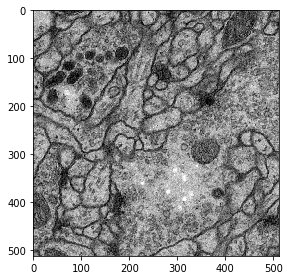

In [2]:
image_stasks = skio.imread('../data/test-volume.tif')
print(image_stasks.shape)
skio.imshow(image_stasks[1])

In [50]:
for i in range(image_stasks.shape[0]):
    skio.imsave('../data/test images/image_{}.tif'.format(i), image_stasks[i])

## data augmentation

In [3]:
trainingset_augmentation('../data/images/', 572, 572, 10000, '../data/masks')

Initialised with 30 image(s) found.
Output directory set to ../data/images/output.

30 ground truth image(s) found.


Processing <PIL.Image.Image image mode=L size=572x572 at 0x1882A31CF28>: 100%|█| 10000/10000 [06:19<00:00, 26.35 Samples/s]


In [9]:
from data_processing import get_allfile
files = get_allfile('../data/images/output')

In [51]:
trainingset_augmentation('../data/test images/', 572, 572, 1000)

Initialised with 30 image(s) found.
Output directory set to ../data/test images/output.

Processing <PIL.Image.Image image mode=L size=572x572 at 0x1883E6ED9B0>: 100%|█| 1000/1000 [00:19<00:00, 50.50 Samples/s]


## Inference

In [2]:
# create model
model = Unet()
#weights_name = 'results/weights/model_unet_1126_1550_cs24.weights'
weights_name = 'results/weights/model_unet_no1234skip_1212_1942_cs24.weights'
# read mean map
with open('mean_map.pic', 'rb') as f:
    mean_map = pickle.load(f)

In [3]:
# load dataset
x, y, t = Unet.load_training_data(by_image=False, img_num=1000, get_test=True)

Processing images_original_image_10.tif_f9516c8c-3009-42b7-805c-81eda475d2cc.tif: 100%|█| 1000/1000 [00:14<00:00, 67.65Images/s]


In [18]:
from keras import backend as K
from keras import layers as KL
from keras.models import Model

def imtermediate_model(model, layer_name):
    imter_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return imter_model
def imtermediate_function(model, layer_name):
    imter_func = K.function([model.model.input], [model.get_layer(layer_name).output])
    return imter_func

In [19]:
m0 = imtermediate_model(model.model, 'upconv_block3_1')
m0.load_weights(weights_name, by_name=True)
y0 = m0.predict(x[0:100])

In [21]:
print(y0.shape)
ind = 1
center_im = aug.crop(x[ind][:,:,0], 92, 92, 388, 388)
#plot_image(center_im)
#multi_plot_image([y0[ind][:,:,9]])

(100, 388, 388, 24)


In [22]:
w_0 = model.model.get_layer('output').weights
w_0 = K.batch_get_value(w_0[0])
#print(w_0.shape)
#print(w_0)
#print(np.mean(w_0))

In [4]:
# prediction
pred_y_x = model.predict(weights_name, x[0:100])
pred_y_t = model.predict(weights_name, t[0:100])

In [25]:
model.model.load_weights(weights_name)
model.model.compile(optimizer=opt.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.model.evaluate(x, y)

1000/1000 [==============================] - ETA: 26 - ETA: 19 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 15s 15ms/step


[1.0605384244918823, 0.5785392456054688]

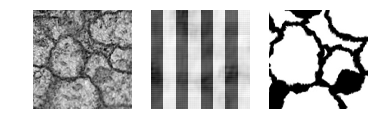

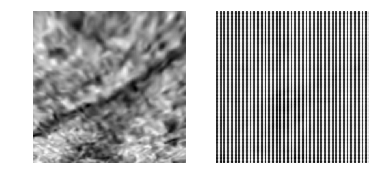

In [6]:
# show some example
ind = 0
multi_plot_image([x[ind][:,:,0], pred_y_x[ind][:,:,0], y[ind][:,:,0]])
center_im = aug.crop(t[ind][:,:,0], 92, 92, 388, 388)
multi_plot_image([center_im, pred_y_t[ind][:,:,0]])

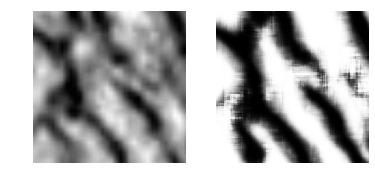

In [69]:
# read image
with Image.open('../data/golgi.tif') as im:
    im = np.array(im) / 255
golgi = aug.crop(im, 30, 30, 50, 50)
multi_plot_image([im, golgi])
# resize & normalize
golgi_resized = np.zeros((1, 572, 572, 1), dtype=np.float32)
golgi_resized[0][:,:,0] = aug.resize(golgi, (572, 572))
golgi_resized -= mean_map
# predict and show
pred_y_g = model.predict(weights_name, golgi_resized)
center_im = aug.crop(golgi_resized[0][:,:,0], 92, 92, 388, 388)
multi_plot_image([center_im, pred_y_g[0][:,:,0]])

In [ ]:
def predict_image(im_path, model, patch_shape):
    # read image
    with Image.open(im_path) as im:
        im = np.array(im) / 255
    assert length(im.shape) == 2
    # convert to array
    patch_shape = np.array(patch_shape) if not isinstance(patch_shape, np.array) else patch_shape
    # compute patch number
    im_shape = np.array(im.shape)
    patch_num = im_shape / patch_shape
    assert (patch_num == np.round(patch_num)).all()
    # patch cordinate
    x, y = np.meshgrid()
    # compute padding shape
    pad_shape = np.round((patch_shape * 572 / 388 - patch_shape) / 2)
    im = np.pad(im, pad_shape, 'symmetric')
    patch_shape_w = patch_shape + pad_shape

376
(4, 572, 572, 1)


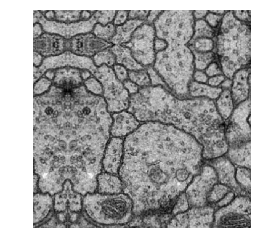

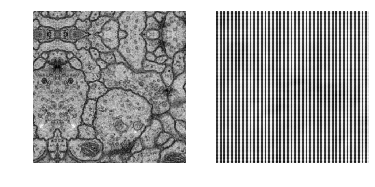

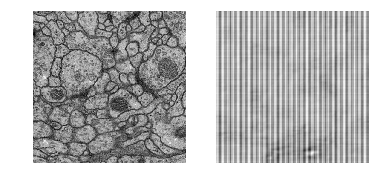

In [6]:
with Image.open('../data/images/image_1.tif') as im:
    im = np.array(im) / 255
# im = aug.resize(im[0:300, 650:], (512, 512))
cs = 256
ps = np.int32((cs * 572 / 388 - cs) / 2)
im1 = np.pad(im, (ps, ps), 'symmetric')
s0 = cs + ps * 2
print(s0)

im_lt = aug.crop(im1, 0, 0, s0, s0)
im_lb = aug.crop(im1, 0, cs, s0, s0)
im_rt = aug.crop(im1, cs, 0, s0, s0)
im_rb = aug.crop(im1, cs, cs, s0, s0)
im_stack = [im_lt, im_lb, im_rt, im_rb]
im_stack = aug.augment_mask(im_stack, aug.resize, dst_size=(572, 572))

ims = np.array(im_stack)
ims = np.reshape(ims, (4, 572, 572, 1))
print(ims.shape)
plot_image(ims[0][:,:,0])

# normalize
ims -= mean_map
y0 = model.predict(weights_name, ims)
y0 = np.squeeze(y0)
multi_plot_image([ims[0][:,:,0], y0[0]])
# resize

#merge
y_t0 = np.zeros((512, 512))
y_t0[0:cs, 0:cs] = aug.resize(y0[0], (cs, cs))
y_t0[0:cs, cs:] = aug.resize(y0[1], (cs, cs))
y_t0[cs:, 0:cs] = aug.resize(y0[2], (cs, cs))
y_t0[cs:, cs:] = aug.resize(y0[3], (cs, cs))

#y_t0 = y_t0 > 0.95
multi_plot_image([im, y_t0])

72
(100, 100)
(122, 122)


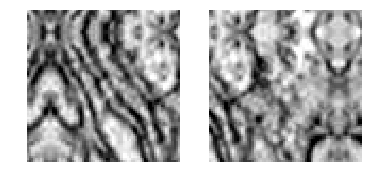

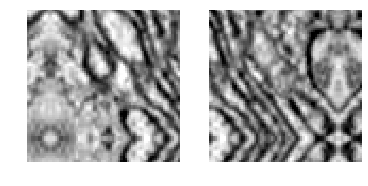

(4, 572, 572, 1)


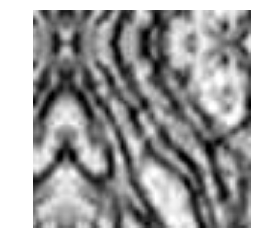

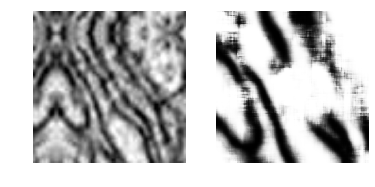

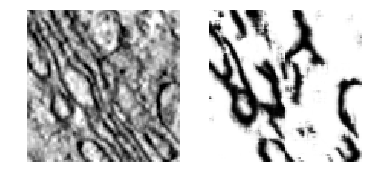

In [158]:
with Image.open('../data/golgi.tif') as im:
    im = np.array(im) / 255
im = im[80:180, 80:180]
cs = 50
ps = np.int32((cs * 572 / 388 - cs) / 2)
im1 = np.pad(im, (ps, ps), 'symmetric')
s0 = cs + ps * 2
print(s0)

im_lt = aug.crop(im1, 0, 0, s0, s0)
im_lb = aug.crop(im1, 0, cs, s0, s0)
im_rt = aug.crop(im1, cs, 0, s0, s0)
im_rb = aug.crop(im1, cs, cs, s0, s0)
im_stack = [im_lt, im_lb, im_rt, im_rb]
im_stack = aug.augment_mask(im_stack, aug.resize, dst_size=(572, 572))
print(im.shape)
print(im1.shape)
multi_plot_image([im_lt, im_lb])
multi_plot_image([im_rt, im_rb])

ims = np.array(im_stack)
ims = np.reshape(ims, (4, 572, 572, 1))
print(ims.shape)
plot_image(ims[0][:,:,0])

# normalize
ims -= mean_map
y0 = model.predict(weights_name, ims)
y0 = np.squeeze(y0)
multi_plot_image([ims[0][:,:,0], y0[0]])
# resize

#merge
y_t0 = np.zeros((100, 100))
y_t0[0:cs, 0:cs] = aug.resize(y0[0], (cs, cs))
y_t0[0:cs, cs:] = aug.resize(y0[1], (cs, cs))
y_t0[cs:, 0:cs] = aug.resize(y0[2], (cs, cs))
y_t0[cs:, cs:] = aug.resize(y0[3], (cs, cs))

multi_plot_image([im, y_t0])

In [3]:
from config import ImageConfig, ConfigOpt
from model import Unet
from data_processing import load_images_train_data, image_data_generator,\
    trainingset_augmentation, load_image_test_data

# configuration
config = ImageConfig()
config.model_description = 'golgi_full'
config.time = '1224_1431'
config.lr = 3e-4
config.operation = ConfigOpt.TRAIN
config.images_dir = '../data/golgi images 0'
config.masks_dir = '../data/golgi masks 0'
config.mean_map = 'mean_map_{}.pic'.format('')

# create model
model = Unet(config=config)

In [4]:
test_x = load_image_test_data(model, config.images_dir)

TypeError: 'NoneType' object cannot be interpreted as an integer

In [7]:
from config import ImageConfig
from config import ConfigOpt
import os
from model import Unet
from dataset import load_image_test_data
import cv2

root_path = os.path.abspath('../')
config_dir = 'model_unet_membrane_cs24_aug_inputbatch_0129_1433'
config = ImageConfig.load_config(root_path, config_dir=config_dir)

In [8]:
config.operation = ConfigOpt.PREDICT
model = Unet(config)

In [5]:
from dataset import get_all_file
from dataset import fullfile
test_images_dir = 'K:\\BIGCAT\\Projects\\EM\\data\\test images'
x = load_image_test_data(model, test_images_dir)
print(x.shape)

Processing image_9.tif: 100%|██████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.15Images/s]


(30, 1, 256, 256)


In [9]:
pred_y = model.run_model(x)

In [ ]:
mean_iou = model.model.evaluate()

In [10]:
from matplotlib import pyplot as plt

In [25]:
import numpy as np

Text(0.5, 1.0, 'Predicted memebrane with thres 0.7')

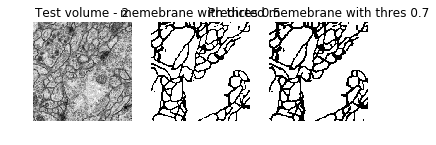

In [46]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(x[0][0], cmap="gray")
axes[0].axis("off")
axes[0].set_title("Test volume - 2")
axes[1].imshow(pred_y[1][0] > 0.5, cmap="gray")
axes[1].axis("off")
axes[1].set_title("memebrane with thres 0.5")
axes[2].imshow(pred_y[1][0] > 0.7, cmap="gray")
axes[2].axis("off")
axes[2].set_title("Predicted memebrane with thres 0.7")
#fig.tight_layout()

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [6]:
from history import print_num
import keras

Using TensorFlow backend.


In [9]:
print_num()

3
